# **Pengembangan Model Klasifikasi Bioaktivitas Senyawa terhadap SARS-CoV-2 melalui Integrasi K-Means Clustering dan K-Nearest Neighbors (KNN)**

## **1. Persiapan Lingkungan**

### **1.1 Instalasi dan Persiapan Awal**

In [ ]:
# Instalasi pustaka utama
!pip install chembl-webresource-client
!pip install rdkit-pypi
!pip install scikit-learn==0.20.3
!pip install matplotlib seaborn tqdm

# Menyiapkan RDKit menggunakan Miniconda
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Instal RDKit melalui conda
!conda install -q -y -c conda-forge rdkit

# Menyiapkan PaDEL
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
!unzip padel.zip
!chmod +x padel.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scikit-learn)
--2024-12-24 09:05:28--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving 

### **1.2 Import Library**

In [ ]:
# Import library utama
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Periksa instalasi pustaka
print("Instalasi dan import pustaka berhasil!")

Instalasi dan import pustaka berhasil!


## **2. Pencarian dan Pengumpulan Data**

### **2.1 Pencarian Dataset**

Tujuan:
Menemukan dataset senyawa yang memiliki aktivitas biologis terhadap SARS-CoV-2 Main Protease (Mpro) menggunakan API ChEMBL.

In [ ]:
# Langkah 1: Cari informasi target SARS-CoV-2 dengan kata kunci yang lebih umum
target = new_client.target
target_query = target.search("SARS-CoV-2")  # Gunakan kata kunci yang lebih umum

# Verifikasi apakah hasil pencarian valid
if target_query is not None:
    # Konversi hasil pencarian ke DataFrame untuk eksplorasi
    targets_df = pd.DataFrame(target_query)

    # Tampilkan daftar semua target yang ditemukan
    print("Daftar target yang ditemukan:")
    print(targets_df[['target_chembl_id', 'pref_name', 'organism']])

    # Pilih target yang relevan secara manual
    mpro_target = targets_df[targets_df['pref_name'] == 'SARS-CoV-2 Main Protease']

    if not mpro_target.empty:
        target_chembl_id = mpro_target.iloc[0]['target_chembl_id']
        print(f"\nID Target yang dipilih: {target_chembl_id}")
        print(f"Nama Target: {mpro_target.iloc[0]['pref_name']}")
        print(f"Organisme: {mpro_target.iloc[0]['organism']}")

        # Langkah 2: Ambil data aktivitas senyawa berdasarkan target_chembl_id
        activity = new_client.activity
        activities = activity.filter(target_chembl_id=target_chembl_id)

        # Konversi data aktivitas ke dalam DataFrame Pandas
        activities_df = pd.DataFrame(activities)

        # Langkah 3: Tampilkan informasi awal dataset
        print("\nJumlah data aktivitas senyawa:", activities_df.shape[0])
        print("Kolom yang tersedia:")
        print(activities_df.columns.tolist())
    else:
        print("Target 'SARS-CoV-2 Main Protease' tidak ditemukan dalam daftar target.")
else:
    print("Pencarian tidak menghasilkan hasil. Silakan coba kata kunci yang berbeda.")

Daftar target yang ditemukan:
     target_chembl_id                            pref_name  \
0       CHEMBL4303835                           SARS-CoV-2   
1       CHEMBL4303836                             SARS-CoV   
2       CHEMBL4523232     Serine--tRNA ligase, cytoplasmic   
3          CHEMBL1835               Thromboxane-A synthase   
4          CHEMBL4028               Thromboxane-A synthase   
...               ...                                  ...   
3018    CHEMBL3832634              Glutamate NMDA receptor   
3019    CHEMBL3988632               L-type calcium channel   
3020    CHEMBL3988641         Voltage-gated sodium channel   
3021    CHEMBL4523985  UDP-glucuronosyltransferases (UGTs)   
3022    CHEMBL4524000                     I-kappa-B kinase   

                                               organism  
0       Severe acute respiratory syndrome coronavirus 2  
1     Severe acute respiratory syndrome-related coro...  
2                                          Homo sap

In [ ]:
# Baca daftar target dari file yang telah disimpan sebelumnya
targets = pd.read_csv("sars_cov2_targets.csv")

# Tentukan kata kunci untuk menyaring target yang relevan
keywords = ["SARS-CoV-2",
            "SARS",
            "Main Protease",
            "Mpro",
            "3C-like",
            "3CL"]


# Filter target berdasarkan kolom 'pref_name' menggunakan kata kunci
relevant_targets = targets[
    targets['pref_name'].str.contains('|'.join(keywords), case=False, na=False)
]

# Tampilkan daftar target yang relevan
print("Daftar target yang relevan:")
print(relevant_targets[['target_chembl_id', 'pref_name', 'organism']])

# Simpan target yang relevan ke file baru
relevant_targets.to_csv("filtered_sars_cov2_targets.csv", index=False)
print("\nDaftar target relevan telah disimpan sebagai 'filtered_sars_cov2_targets.csv'.")

Daftar target yang relevan:
  target_chembl_id                            pref_name  \
0    CHEMBL4303835                           SARS-CoV-2   
1    CHEMBL4303836                             SARS-CoV   
5       CHEMBL3927  SARS coronavirus 3C-like proteinase   

                                            organism  
0    Severe acute respiratory syndrome coronavirus 2  
1  Severe acute respiratory syndrome-related coro...  
5  Severe acute respiratory syndrome-related coro...  

Daftar target relevan telah disimpan sebagai 'filtered_sars_cov2_targets.csv'.


In [ ]:
# Tentukan target-target relevan secara eksplisit
relevant_target_ids = ["CHEMBL4303835", "CHEMBL4303836", "CHEMBL3927"]

# Definisikan fungsi untuk mengambil data aktivitas berdasarkan target CHEMBL ID
def targetFilter(target_id):
    activity = new_client.activity
    # Filter aktivitas berdasarkan target CHEMBL ID dan tipe standar IC50
    res = activity.filter(target_chembl_id=target_id)
    df = pd.DataFrame.from_dict(res)
    return df

# Ambil data aktivitas untuk setiap target relevan
dataframes = []
for target_id in relevant_target_ids:
    print(f"Retrieving data for target: {target_id}")
    try:
        df = targetFilter(target_id)
        if not df.empty:
            dataframes.append(df)
    except Exception as e:
        print(f"Failed to retrieve data for target {target_id}: {e}")

# Gabungkan semua data menjadi satu DataFrame
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"\nJumlah total data aktivitas senyawa: {combined_df.shape[0]}")
    # Simpan dataset gabungan ke file
    combined_df.to_csv("raw_sars_cov2_activity_data2.csv", index=False)
    print("Dataset aktivitas gabungan telah disimpan sebagai 'raw_sars_cov2_activity_data.csv'.")
else:
    print("Tidak ada data aktivitas senyawa yang berhasil diambil.")

Retrieving data for target: CHEMBL4303835
Retrieving data for target: CHEMBL4303836
Retrieving data for target: CHEMBL3927


<ipython-input-54-e0d68ac2259b>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dataframes, ignore_index=True)



Jumlah total data aktivitas senyawa: 40521
Dataset aktivitas gabungan telah disimpan sebagai 'raw_sars_cov2_activity_data.csv'.


### **2.2 Filter Berdasarkan IC50**

In [ ]:
# Baca dataset aktivitas gabungan
df = pd.read_csv("raw_sars_cov2_activity_data2.csv")

# Periksa jumlah awal data
print(f"Jumlah total data awal: {df.shape[0]}")

# Pilih kolom yang relevan untuk analisis
columns_of_interest = ['molecule_chembl_id', 'canonical_smiles', 'standard_type', 'standard_value', 'standard_units']

# Filter dataset hanya untuk tipe aktivitas IC50
ic50_data = df[
    (df['standard_type'] == 'IC50') &
    (df['standard_value'].notnull()) &
    (df['canonical_smiles'].notnull())
]

# Pilih hanya kolom yang relevan
ic50_data = ic50_data[columns_of_interest]

# Tampilkan informasi dataset yang difilter
print("Jumlah data setelah filter IC50:", ic50_data.shape[0])
print(ic50_data.head())

# Simpan dataset yang sudah difilter
output_path = "filtered_ic50_data.csv"
ic50_data.to_csv(output_path, index=False)
print(f"Dataset telah difilter dan disimpan sebagai '{output_path}'.")

Jumlah total data awal: 40521
Jumlah data setelah filter IC50: 10530
   molecule_chembl_id                                   canonical_smiles  \
18      CHEMBL3301610  CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...   
19          CHEMBL682             CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O   
20       CHEMBL264241  CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](...   
21        CHEMBL46740  Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2...   
22       CHEMBL504323  COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1[C@@H](Cc1ccc(O)...   

   standard_type  standard_value standard_units  
18          IC50          6620.0             nM  
19          IC50          5150.0             nM  
20          IC50          4640.0             nM  
21          IC50          3440.0             nM  
22          IC50          7870.0             nM  
Dataset telah difilter dan disimpan sebagai 'filtered_ic50_data.csv'.


<ipython-input-55-2d351d70d56d>:2: DtypeWarning: Columns (0,13,14,16,18,30,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("raw_sars_cov2_activity_data2.csv")


## **3. Eksplorasi dan Preprocessing Data**

### **3.1 Pembersihan Dataset**

In [ ]:
# Baca dataset hasil filter IC50
df = pd.read_csv("filtered_ic50_data.csv")

# Periksa jumlah awal data
print(f"Jumlah data awal: {df.shape[0]}")

# Periksa data yang hilang
missing_values = df.isnull().sum()
print("\nJumlah nilai yang hilang per kolom:")
print(missing_values)

# Hapus data yang memiliki nilai kosong
df_cleaned = df.dropna()
print(f"\nJumlah data setelah menghapus nilai kosong: {df_cleaned.shape[0]}")

# Simpan dataset yang telah dibersihkan
output_path = "cleaned_ic50_data.csv"
df_cleaned.to_csv(output_path, index=False)
print(f"\nDataset yang telah dibersihkan disimpan sebagai '{output_path}'.")

Jumlah data awal: 10530

Jumlah nilai yang hilang per kolom:
molecule_chembl_id    0
canonical_smiles      0
standard_type         0
standard_value        0
standard_units        0
dtype: int64

Jumlah data setelah menghapus nilai kosong: 10530

Dataset yang telah dibersihkan disimpan sebagai 'cleaned_ic50_data.csv'.


In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df = df[selection]

In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL3301610,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,6620.00
1,CHEMBL682,CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O,5150.00
2,CHEMBL264241,CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](...,4640.00
3,CHEMBL46740,Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2...,3440.00
4,CHEMBL504323,COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1[C@@H](Cc1ccc(O)...,7870.00
...,...,...,...
10525,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,380.19
10526,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.00
10527,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,161.00
10528,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.96


### **3.2 Pemberian Label Bioaktivitas**

In [ ]:
# Definisikan fungsi untuk memberikan label berdasarkan nilai standard_value
bioactivity_threshold = []
for i in df.standard_value:
    if float(i) >= 10000:
        bioactivity_threshold.append("inactive")
    elif float(i) <= 1000:
        bioactivity_threshold.append("active")
    else:
        bioactivity_threshold.append("intermediate")

# Tambahkan kolom baru untuk label bioaktivitas
df['bioactivity_label'] = bioactivity_threshold

# Tampilkan distribusi label
print("Distribusi label bioaktivitas:")
print(df['bioactivity_label'].value_counts())

# Simpan dataset dengan label bioaktivitas ke file baru
df.to_csv("labeled_bioactivity_data.csv", index=False)
print("Dataset dengan label bioaktivitas telah disimpan sebagai 'labeled_bioactivity_data.csv'.")

Distribusi label bioaktivitas:
bioactivity_label
inactive        9660
intermediate     562
active           308
Name: count, dtype: int64
Dataset dengan label bioaktivitas telah disimpan sebagai 'labeled_bioactivity_data.csv'.


## **4. Perhitungan Deskriptor Molekuler dan Fingerprint**

### **4.1 Pembersihan SMILES**

In [ ]:
# Baca dataset hasil pemberian label bioaktivitas
df_eda = pd.read_csv("labeled_bioactivity_data.csv")

# Hapus kolom canonical_smiles untuk sementara
df_no_smiles = df_eda.drop(columns='canonical_smiles')

# Proses kolom canonical_smiles untuk memilih senyawa terpanjang
smiles = []

for i in df_eda.canonical_smiles.tolist():
    cpd = str(i).split('.')  # Pisahkan jika ada campuran senyawa
    cpd_longest = max(cpd, key=len)  # Ambil senyawa terpanjang
    smiles.append(cpd_longest)

# Konversi hasil ke Series
smiles = pd.Series(smiles, name='canonical_smiles')

# Gabungkan kembali dengan dataset tanpa kolom smiles
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)

# Simpan dataset hasil pembersihan SMILES
df_clean_smiles.to_csv("cleaned_smiles_data.csv", index=False)

# Tampilkan informasi dataset
print("Dataset setelah pembersihan SMILES telah disimpan sebagai 'cleaned_smiles_data.csv'.")
print(df_clean_smiles.head())

Dataset setelah pembersihan SMILES telah disimpan sebagai 'cleaned_smiles_data.csv'.
  molecule_chembl_id  standard_value bioactivity_label  \
0      CHEMBL3301610          6620.0      intermediate   
1          CHEMBL682          5150.0      intermediate   
2       CHEMBL264241          4640.0      intermediate   
3        CHEMBL46740          3440.0      intermediate   
4       CHEMBL504323          7870.0      intermediate   

                                    canonical_smiles  
0  CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...  
1             CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O  
2  CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](...  
3  Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2...  
4  COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1[C@@H](Cc1ccc(O)...  


### **4.2 Perhitungan Lipinski dan Deskriptor Molekuler**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import numpy as np
import pandas as pd

# Definisikan fungsi untuk menghitung Lipinski Deskriptor
def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)  # Konversi SMILES ke objek molekul RDKit
        moldata.append(mol)

    baseData = np.arange(1, 1)  # Array kosong untuk menampung hasil deskriptor
    i = 0
    for mol in moldata:
        # Hitung deskriptor molekul
        desc_MolWt = Descriptors.MolWt(mol)  # Molecular Weight (MW)
        desc_MolLogP = Descriptors.MolLogP(mol)  # LogP
        desc_NumHDonors = Lipinski.NumHDonors(mol)  # Number of Hydrogen Donors
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)  # Number of Hydrogen Acceptors

        row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])
        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i += 1

    # Nama kolom deskriptor
    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors

# Baca dataset hasil pembersihan SMILES
df_clean_smiles = pd.read_csv("cleaned_smiles_data.csv")

# Hitung deskriptor untuk kolom SMILES
df_lipinski = lipinski(df_clean_smiles['canonical_smiles'])

# Simpan hasil deskriptor ke file
df_lipinski.to_csv("lipinski_descriptors.csv", index=False)

# Tampilkan informasi deskriptor
print("Lipinski Deskriptor telah dihitung dan disimpan sebagai 'lipinski_descriptors.csv'.")
print(df_lipinski.head())

Lipinski Deskriptor telah dihitung dan disimpan sebagai 'lipinski_descriptors.csv'.
         MW     LogP  NumHDonors  NumHAcceptors
0   506.605  4.93692         1.0            8.0
1   355.869  5.17920         2.0            4.0
2  1140.254 -0.92710        14.0           17.0
3   470.613  6.33102         2.0            5.0
4   608.735  6.85940         1.0            8.0


### **4.4 Menggabungkan Data**

In [ ]:
# Menggabungkan dataset SMILES bersih dengan deskriptor Lipinski
df_combined = pd.concat([df_clean_smiles, df_lipinski], axis=1)

# Menampilkan informasi dataset gabungan
print("Dataset setelah digabungkan dengan deskriptor Lipinski:")
print(df_combined.head())

# Simpan dataset gabungan ke dalam file CSV
df_combined.to_csv("combined_dataset_with_lipinski.csv", index=False)
print("Dataset gabungan telah disimpan sebagai 'combined_dataset_with_lipinski.csv'.")

Dataset setelah digabungkan dengan deskriptor Lipinski:
  molecule_chembl_id  standard_value bioactivity_label  \
0      CHEMBL3301610          6620.0      intermediate   
1          CHEMBL682          5150.0      intermediate   
2       CHEMBL264241          4640.0      intermediate   
3        CHEMBL46740          3440.0      intermediate   
4       CHEMBL504323          7870.0      intermediate   

                                    canonical_smiles        MW     LogP  \
0  CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...   506.605  4.93692   
1             CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O   355.869  5.17920   
2  CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](...  1140.254 -0.92710   
3  Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2...   470.613  6.33102   
4  COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1[C@@H](Cc1ccc(O)...   608.735  6.85940   

   NumHDonors  NumHAcceptors  
0         1.0            8.0  
1         2.0            4.0  
2        14.0           17.0  
3         2.0       

### **4.5 Konversi IC50 menjadi pIC50**

In [ ]:
# Fungsi untuk normalisasi nilai IC50
def norm_value(input):
    norm = []
    for i in input['standard_value']:
        # Batasi nilai IC50 maksimum menjadi 100 juta (100,000,000 nM)
        if i > 100000000:
            i = 100000000
        norm.append(i)
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)  # Hapus kolom IC50 asli
    return x

# Fungsi untuk konversi IC50 ke pIC50
def pIC50(input):
    pIC50 = []
    for i in input['standard_value_norm']:
        # Konversi dari nM ke Molar (M) dan hitung pIC50
        molar = i * (10 ** -9)
        pIC50.append(-np.log10(molar))
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)  # Hapus kolom normalisasi
    return x

# Normalisasi nilai IC50
df_norm = norm_value(df_combined)

# Konversi nilai IC50 yang telah dinormalisasi menjadi pIC50
df_final = pIC50(df_norm)

# Tampilkan informasi dataset setelah konversi
print("Dataset setelah konversi IC50 ke pIC50:")
print(df_final.head())

# Simpan dataset akhir
df_final.to_csv("final_dataset_with_pIC50.csv", index=False)
print("Dataset dengan pIC50 telah disimpan sebagai 'final_dataset_with_pIC50.csv'.")

Dataset setelah konversi IC50 ke pIC50:
  molecule_chembl_id bioactivity_label  \
0      CHEMBL3301610      intermediate   
1          CHEMBL682      intermediate   
2       CHEMBL264241      intermediate   
3        CHEMBL46740      intermediate   
4       CHEMBL504323      intermediate   

                                    canonical_smiles        MW     LogP  \
0  CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...   506.605  4.93692   
1             CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O   355.869  5.17920   
2  CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](...  1140.254 -0.92710   
3  Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2...   470.613  6.33102   
4  COc1cc2c3cc1Oc1c(OC)c(OC)cc4c1[C@@H](Cc1ccc(O)...   608.735  6.85940   

   NumHDonors  NumHAcceptors     pIC50  
0         1.0            8.0  5.179142  
1         2.0            4.0  5.288193  
2        14.0           17.0  5.333482  
3         2.0            5.0  5.463442  
4         1.0            8.0  5.104025  
Dataset de

### **4.6 Menghapus Intermediate Class**

In [ ]:
# Baca dataset yang telah disimpan sebelumnya
df_final = pd.read_csv("final_dataset_with_pIC50.csv")

# Hapus data dengan kelas 'intermediate'
df_2class = df_final[df_final['bioactivity_label'] != 'intermediate']

# Tampilkan informasi dataset setelah penghapusan kelas 'intermediate'
print("Dataset setelah menghapus kelas 'intermediate':")
print(df_2class.head())

# Periksa apakah masih ada nilai kosong
print("\nJumlah nilai kosong per kolom setelah penghapusan kelas 'intermediate':")
print(df_2class.isna().sum())

# Simpan dataset yang telah diperbarui
df_2class.to_csv("final_dataset_2class.csv", index=False)
print("Dataset dengan hanya kelas 'active' dan 'inactive' telah disimpan sebagai 'final_dataset_2class.csv'.")

Dataset setelah menghapus kelas 'intermediate':
   molecule_chembl_id bioactivity_label  \
5        CHEMBL590799          inactive   
11       CHEMBL254219            active   
12         CHEMBL1751            active   
13      CHEMBL1526240          inactive   
19          CHEMBL496            active   

                                     canonical_smiles       MW     LogP  \
5   CN(C)C(=O)COC(=O)Cc1ccc(OC(=O)c2ccc(NC(=N)N)cc...  398.419  1.38507   
11  C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...  764.950  3.24730   
12  C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...  780.949  2.21810   
13  CC(C)=CCCC1(C)C=Cc2c(O)c3c(c(CC=C(C)C)c2O1)OC1...  630.778  7.03110   
19        Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl  406.907  6.60900   

    NumHDonors  NumHAcceptors     pIC50  
5          3.0            6.0  4.301030  
11         5.0           13.0  6.638272  
12         6.0           14.0  6.721246  
13         3.0            7.0  4.873869  
19         2.0            2.0  6

## **Plotting**

### **Plot frekuensi dari dua kelas bioaktifitas**

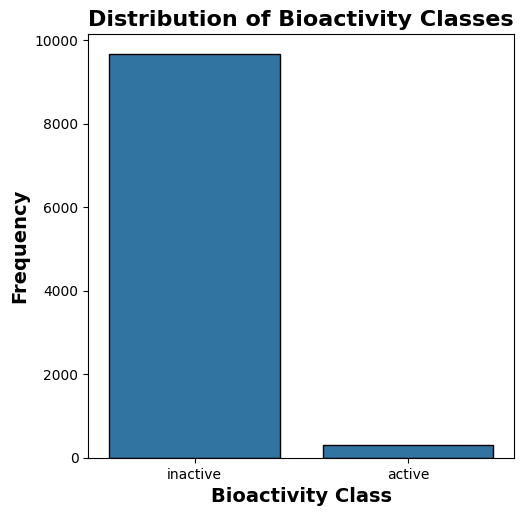

Plot distribusi kelas bioaktivitas telah disimpan sebagai 'bioactivity_class_distribution.pdf'.


In [ ]:
# Plot distribusi kelas bioaktivitas
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity_label', data=df_2class, edgecolor='black')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Bioactivity Classes', fontsize=16, fontweight='bold')

# Simpan plot sebagai file PDF
output_plot_path = 'bioactivity_class_distribution.pdf'
plt.savefig(output_plot_path)

# Tampilkan plot
plt.show()

print(f"Plot distribusi kelas bioaktivitas telah disimpan sebagai '{output_plot_path}'.")

### **Scatter plot MW vs LogP**

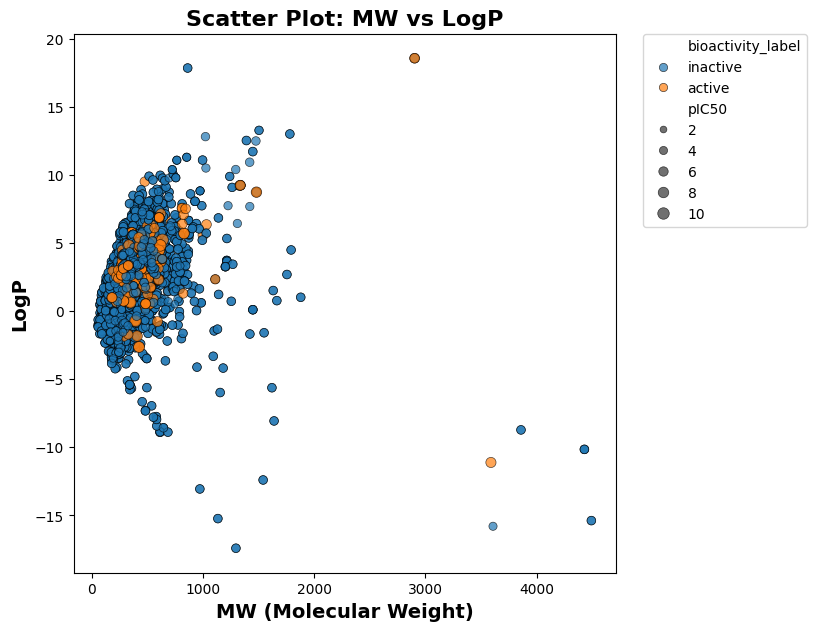

Scatter plot MW vs LogP telah disimpan sebagai 'scatter_plot_MW_vs_LogP.pdf'.


In [ ]:
# Scatter plot MW vs LogP
plt.figure(figsize=(7, 7))

# Plot menggunakan scatterplot dari seaborn
sns.scatterplot(
    x='MW',
    y='LogP',
    data=df_2class,
    hue='bioactivity_label',
    size='pIC50',
    edgecolor='black',
    alpha=0.7
)

# Penyesuaian label dan legenda
plt.xlabel('MW (Molecular Weight)', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.title('Scatter Plot: MW vs LogP', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Simpan plot sebagai file PDF
output_scatter_plot_path = 'scatter_plot_MW_vs_LogP.pdf'
plt.savefig(output_scatter_plot_path, bbox_inches='tight')

# Tampilkan plot
plt.show()

print(f"Scatter plot MW vs LogP telah disimpan sebagai '{output_scatter_plot_path}'.")

## **5. Fingerprint Molecular**

### **5.1 Persiapan File SMILES untuk PaDEL**

In [ ]:
# Pilih kolom yang diperlukan untuk file SMILES
selection = ['canonical_smiles', 'molecule_chembl_id']
df_selection = df_2class[selection]

# Simpan data ke dalam file SMILES (.smi) yang diperlukan oleh PaDEL
smiles_file_path = 'molecule.smi'
df_selection.to_csv(smiles_file_path, sep='\t', index=False, header=False)

# Tampilkan beberapa baris pertama dari file .smi untuk verifikasi
!cat molecule.smi | head -5

# Hitung jumlah baris dalam file .smi untuk memastikan semua senyawa tercatat
!cat molecule.smi | wc -l

CN(C)C(=O)COC(=O)Cc1ccc(OC(=O)c2ccc(NC(=N)N)cc2)cc1	CHEMBL590799
C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[C@@H](O)C[C@H](O[C@H]4CC[C@@]5(C)[C@H](CC[C@@H]6[C@@H]5CC[C@]5(C)[C@@H](C7=CC(=O)OC7)CC[C@]65O)C4)O[C@@H]3C)O[C@@H]2C)C[C@H](O)[C@@H]1O	CHEMBL254219
C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[C@@H](O)C[C@H](O[C@H]4CC[C@@]5(C)[C@H](CC[C@@H]6[C@@H]5C[C@@H](O)[C@]5(C)[C@@H](C7=CC(=O)OC7)CC[C@]65O)C4)O[C@@H]3C)O[C@@H]2C)C[C@H](O)[C@@H]1O	CHEMBL1751
CC(C)=CCCC1(C)C=Cc2c(O)c3c(c(CC=C(C)C)c2O1)OC12C(=CC4CC1C(C)(C)OC2(C/C=C(/C)C(=O)O)C4O)C3=O	CHEMBL1526240
Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl	CHEMBL496
9968


### **5.2. Menjalankan PaDEL-Descriptor**

In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Streaming output truncated to the last 5000 lines.
Processing CHEMBL1551716 in molecule.smi (5019/9968). Average speed: 0.21 s/mol.
Processing CHEMBL1551716 in molecule.smi (5018/9968). Average speed: 0.21 s/mol.
Processing CHEMBL1480686 in molecule.smi (5021/9968). Average speed: 0.21 s/mol.
Processing CHEMBL1480686 in molecule.smi (5020/9968). Average speed: 0.21 s/mol.
Processing CHEMBL499915 in molecule.smi (5023/9968). Average speed: 0.21 s/mol.
Processing CHEMBL499915 in molecule.smi (5022/9968). Average speed: 0.21 s/mol.
Processing CHEMBL4303577 in molecule.smi (5025/9968). Average speed: 0.21 s/mol.
Processing CHEMBL4303577 in molecule.smi (5024/9968). Average speed: 0.21 s/mol.
Processing CHEMBL1907009 in molecule.smi (5027/9968). Average speed: 0.21 s/mol.
Processing CHEMBL1907009 in molecule.smi (5026/9968). Average speed: 0.21 s/mol.
Processing CHEMBL254316 in molecule.smi (5028/9968). Average speed: 0.21 s/mol.
Processing CHEMBL254316 in molecule.smi (5029/9968). Average 

### **5.3 Menggabungkan Fingerprint dengan Dataset**

In [ ]:
# Memuat hasil fingerprint dari PaDEL
fingerprint_file_path = "descriptors_output.csv"
df_X = pd.read_csv(fingerprint_file_path)

# Pastikan kolom 'Name' di fingerprint sesuai dengan 'molecule_chembl_id'
df_X = df_X.rename(columns={"Name": "molecule_chembl_id"})

# Gabungkan dataset fingerprint dengan dataset bioaktivitas
df_combined_fingerprint = pd.merge(df_2class, df_X, on="molecule_chembl_id")

# Tampilkan dimensi dataset setelah penggabungan
print("Dimensi dataset setelah penggabungan fingerprint:", df_combined_fingerprint.shape)

# Simpan dataset hasil penggabungan
combined_fingerprint_file_path = "final_dataset_with_fingerprints.csv"
df_combined_fingerprint.to_csv(combined_fingerprint_file_path, index=False)

print(f"Dataset dengan fingerprint telah disimpan sebagai '{combined_fingerprint_file_path}'.")

Dimensi dataset setelah penggabungan fingerprint: (22744, 889)
Dataset dengan fingerprint telah disimpan sebagai 'final_dataset_with_fingerprints.csv'.


### **5.4 Pemeriksaan Data Setelah Penggabungan**

In [ ]:
# Periksa kolom dengan nilai hilang
missing_values = df_combined_fingerprint.isnull().sum()
print("Kolom dengan nilai hilang:")
print(missing_values[missing_values > 0])

# Hapus baris dengan nilai hilang
df_cleaned = df_combined_fingerprint.dropna()

# Verifikasi bahwa nilai hilang telah dihapus
print("\nSetelah menghapus baris dengan nilai hilang:")
missing_values_cleaned = df_cleaned.isnull().sum()
print(missing_values_cleaned[missing_values_cleaned > 0])

# Tampilkan dimensi dataset setelah pembersihan
print(f"\nDimensi dataset setelah menghapus nilai hilang: {df_cleaned.shape}")

# Simpan dataset setelah pembersihan
cleaned_dataset_path = "final_dataset_no_missing_values.csv"
df_cleaned.to_csv(cleaned_dataset_path, index=False)

print(f"Dataset tanpa nilai hilang telah disimpan sebagai '{cleaned_dataset_path}'.")

Kolom dengan nilai hilang:
PubchemFP0      4
PubchemFP1      4
PubchemFP2      4
PubchemFP3      4
PubchemFP4      4
               ..
PubchemFP876    4
PubchemFP877    4
PubchemFP878    4
PubchemFP879    4
PubchemFP880    4
Length: 881, dtype: int64

Setelah menghapus baris dengan nilai hilang:
Series([], dtype: int64)

Dimensi dataset setelah menghapus nilai hilang: (22740, 889)
Dataset tanpa nilai hilang telah disimpan sebagai 'final_dataset_no_missing_values.csv'.


## **6. Clustering dengan K-Means**

### **6.1 Clustering Molekuler**

#### **Persiapan Fitur untuk Clustering**

In [ ]:
# Baca dataset final tanpa nilai hilang
df = pd.read_csv("final_dataset_no_missing_values.csv")

# Pilih fitur yang relevan untuk clustering
features = df[['MW', 'LogP', 'NumHDonors', 'NumHAcceptors'] + [col for col in df.columns if col.startswith('PubchemFP')]]

# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Simpan hasil normalisasi untuk referensi
pd.DataFrame(normalized_features, columns=features.columns).to_csv("normalized_features.csv", index=False)

#### **Tentukan Jumlah Cluster Optimal**

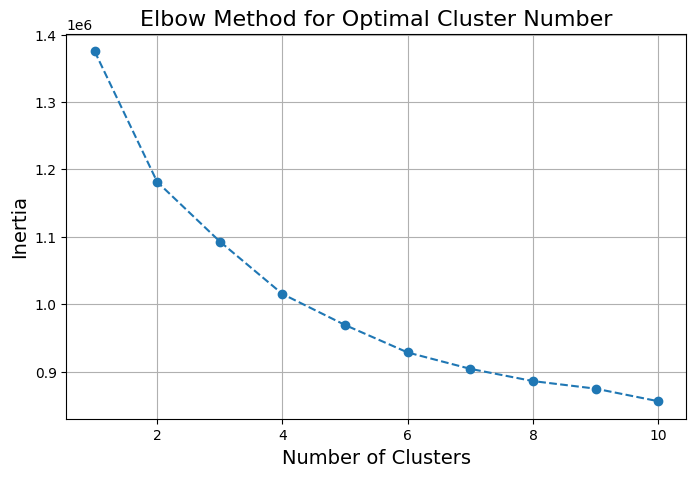

In [ ]:
# Tentukan range jumlah cluster untuk evaluasi
cluster_range = range(1, 11)
inertia = []

# Hitung inertia untuk setiap jumlah cluster
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method for Optimal Cluster Number', fontsize=16)
plt.grid()
plt.savefig('elbow_method_plot.pdf')

In [ ]:
pip install kneed

     |████████████████████████████████| 15.7 MB 4.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 


In [ ]:
from kneed import KneeLocator

# Gunakan KneeLocator untuk menemukan titik "knee" pada Elbow Method
knee = KneeLocator(cluster_range, inertia, curve="convex", direction="decreasing")

# Tampilkan jumlah cluster optimal
optimal_k = knee.knee
print(f"Jumlah cluster optimal berdasarkan Elbow Method: {optimal_k}")

Jumlah cluster optimal berdasarkan Elbow Method: 4


#### **Lakukan Clustering**

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(normalized_features)

# Simpan hasil clustering
df.to_csv("dataset_with_clusters.csv", index=False)

### **6.2 Visualisasi Cluster**

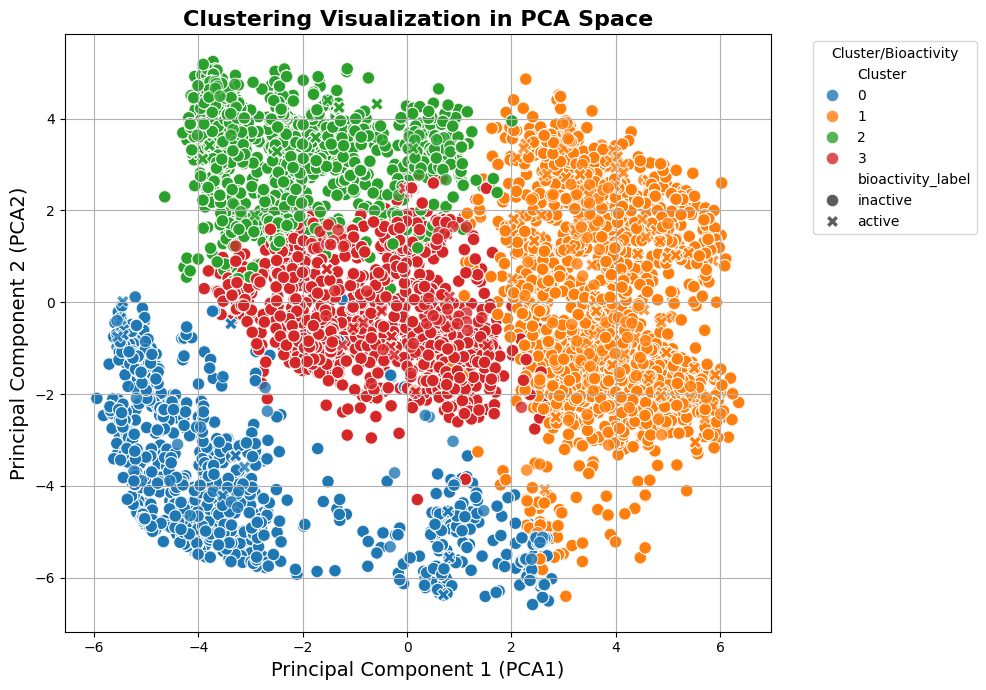

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Lakukan PCA untuk mereduksi dimensi data ke 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)

# Tambahkan hasil PCA ke dataset
df['PCA1'] = pca_features[:, 0]
df['PCA2'] = pca_features[:, 1]

# Plot hasil clustering dalam ruang PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    style='bioactivity_label',
    data=df,
    palette='tab10',
    alpha=0.8,
    s=80
)

plt.title('Clustering Visualization in PCA Space', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1 (PCA1)', fontsize=14)
plt.ylabel('Principal Component 2 (PCA2)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster/Bioactivity')
plt.grid()
plt.tight_layout()

# Simpan plot
plt.savefig('pca_clustering_visualization.pdf')
plt.show()

### **6.3 Analisis Cluster**

#### **Distribusi nilai pIC50 pada setiap cluster**

<ipython-input-92-4352280fe02d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='pIC50', data=df, palette='tab10')


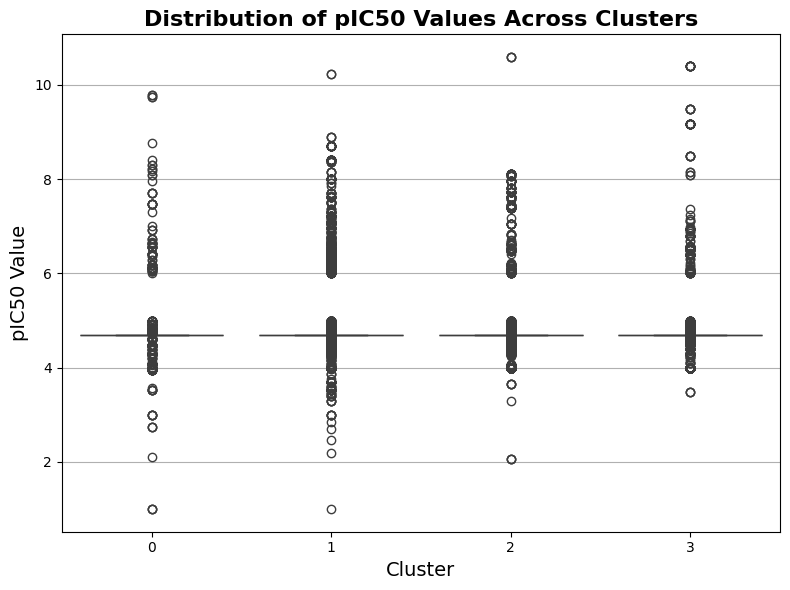

In [ ]:
# Boxplot distribusi nilai pIC50 pada setiap cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='pIC50', data=df, palette='tab10')
plt.title('Distribution of pIC50 Values Across Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('pIC50 Value', fontsize=14)
plt.grid(axis='y')
plt.tight_layout()

# Simpan plot
plt.savefig('pIC50_distribution_clusters.pdf')
plt.show()

#### **Karakteristik deskriptor molekuler pada masing-masing cluster**

In [ ]:
# Hitung rata-rata nilai deskriptor molekuler pada setiap cluster
cluster_analysis = df.groupby('Cluster')[['MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50']].mean()

# Tampilkan hasil analisis cluster
print("Karakteristik rata-rata tiap cluster:")
print(cluster_analysis)

# Simpan hasil analisis cluster ke file
cluster_analysis.to_csv('cluster_analysis.csv', index=True)


Karakteristik rata-rata tiap cluster:
                 MW      LogP  NumHDonors  NumHAcceptors     pIC50
Cluster                                                           
0        318.384970  1.094972    2.513591       5.244862  4.708789
1        431.616052  3.386433    2.032990       6.156110  4.776886
2        362.394892  3.156210    1.961883       4.789594  4.716267
3        345.736653  3.324669    1.283302       3.428200  4.684605


#### **Identifikasi karakteristik unik pada cluster**

In [ ]:
# Statistik deskriptif pada setiap cluster
cluster_stats = df.groupby('Cluster')[['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']].describe()

# Tampilkan statistik deskriptif
print("Statistik deskriptif tiap cluster:")
print(cluster_stats)

# Simpan statistik deskriptif ke file
cluster_stats.to_csv('cluster_statistics.csv', index=True)


Statistik deskriptif tiap cluster:
             MW                                                                \
          count        mean         std      min        25%      50%      75%   
Cluster                                                                         
0        4525.0  318.384970  195.285862   59.068  185.17900  281.484  382.541   
1        7578.0  431.616052  272.295206   93.129  310.94525  394.523  495.027   
2        5247.0  362.394892  152.785294   94.113  275.22000  337.416  415.795   
3        5390.0  345.736653  136.266396  108.144  270.33900  324.399  400.975   

                     LogP            ... NumHDonors       NumHAcceptors  \
              max   count      mean  ...        75%   max         count   
Cluster                              ...                                  
0        1639.937  4525.0  1.094972  ...        3.0  24.0        4525.0   
1        4491.945  7578.0  3.386433  ...        2.0  63.0        7578.0   
2        1793.125  524

### **6.4 Integrasi Cluster ke Dataset**

In [ ]:
# Tambahkan hasil clustering sebagai fitur baru
df['Cluster'] = df['Cluster']

# Simpan dataset dengan fitur cluster
df.to_csv('dataset_with_clusters_final.csv', index=False)

print("Dataset final dengan fitur cluster telah disimpan sebagai 'dataset_with_clusters_final.csv'.")

Dataset final dengan fitur cluster telah disimpan sebagai 'dataset_with_clusters_final.csv'.


## **7. Pemodelan Machine Learning**

### **7.1 Split Dataset**

In [ ]:
# Langkah 1: Muat dataset dengan fitur clustering
dataset_path = 'dataset_with_clusters_final.csv'
df = pd.read_csv(dataset_path)
print(f"Dataset dimuat dari '{dataset_path}' dengan dimensi: {df.shape}")

# Langkah 2: Tentukan fitur dan label
# Target (label)
y = df['bioactivity_label']

# Dataset tanpa KMeans (hapus kolom Cluster)
X_no_kmeans = df.drop(columns=['bioactivity_label', 'Cluster'])

# Dataset dengan KMeans (sertakan kolom Cluster)
X_with_kmeans = df.drop(columns=['bioactivity_label'])

# Langkah 3: Split dataset
# Split dataset tanpa KMeans
X_train_no_kmeans, X_test_no_kmeans, y_train_no_kmeans, y_test_no_kmeans = train_test_split(
    X_no_kmeans, y, test_size=0.2, random_state=42, stratify=y
)

# Split dataset dengan KMeans
X_train_with_kmeans, X_test_with_kmeans, y_train_with_kmeans, y_test_with_kmeans = train_test_split(
    X_with_kmeans, y, test_size=0.2, random_state=42, stratify=y
)

# Langkah 4: Simpan hasil pembagian dataset ke file CSV
X_train_no_kmeans.to_csv('X_train_no_kmeans.csv', index=False)
X_test_no_kmeans.to_csv('X_test_no_kmeans.csv', index=False)
y_train_no_kmeans.to_csv('y_train_no_kmeans.csv', index=False)
y_test_no_kmeans.to_csv('y_test_no_kmeans.csv', index=False)

X_train_with_kmeans.to_csv('X_train_with_kmeans.csv', index=False)
X_test_with_kmeans.to_csv('X_test_with_kmeans.csv', index=False)
y_train_with_kmeans.to_csv('y_train_with_kmeans.csv', index=False)
y_test_with_kmeans.to_csv('y_test_with_kmeans.csv', index=False)

# Langkah 5: Output ringkasan pembagian
print("Pembagian dataset selesai:")
print(f"- X_train_no_kmeans: {X_train_no_kmeans.shape}")
print(f"- X_test_no_kmeans: {X_test_no_kmeans.shape}")
print(f"- y_train_no_kmeans: {y_train_no_kmeans.shape}")
print(f"- y_test_no_kmeans: {y_test_no_kmeans.shape}")
print(f"- X_train_with_kmeans: {X_train_with_kmeans.shape}")
print(f"- X_test_with_kmeans: {X_test_with_kmeans.shape}")
print(f"- y_train_with_kmeans: {y_train_with_kmeans.shape}")
print(f"- y_test_with_kmeans: {y_test_with_kmeans.shape}")

Dataset dimuat dari 'dataset_with_clusters_final.csv' dengan dimensi: (22740, 892)
Pembagian dataset selesai:
- X_train_no_kmeans: (18192, 890)
- X_test_no_kmeans: (4548, 890)
- y_train_no_kmeans: (18192,)
- y_test_no_kmeans: (4548,)
- X_train_with_kmeans: (18192, 891)
- X_test_with_kmeans: (4548, 891)
- y_train_with_kmeans: (18192,)
- y_test_with_kmeans: (4548,)


### **7.2 KNN tanpa Hasil K-Means**

In [ ]:
# Langkah 1: Muat dataset tanpa KMeans
X_train_no_kmeans = pd.read_csv('X_train_no_kmeans.csv')
X_test_no_kmeans = pd.read_csv('X_test_no_kmeans.csv')
y_train_no_kmeans = pd.read_csv('y_train_no_kmeans.csv').values.ravel()
y_test_no_kmeans = pd.read_csv('y_test_no_kmeans.csv').values.ravel()

# Langkah 2: Hapus kolom non-numerik (jika ada)
X_train_no_kmeans = X_train_no_kmeans.select_dtypes(include=['float64', 'int64'])
X_test_no_kmeans = X_test_no_kmeans.select_dtypes(include=['float64', 'int64'])

# Pastikan dataset tidak kosong setelah filtering
print(f"Dimensi X_train setelah filtering: {X_train_no_kmeans.shape}")
print(f"Dimensi X_test setelah filtering: {X_test_no_kmeans.shape}")

# Langkah 3: Inisialisasi model KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

# Langkah 4: Latih model menggunakan dataset tanpa KMeans
knn.fit(X_train_no_kmeans, y_train_no_kmeans)

# Langkah 5: Prediksi pada test set
y_pred = knn.predict(X_test_no_kmeans)
y_proba = knn.predict_proba(X_test_no_kmeans)[:, 1]  # Probabilitas untuk kelas positif (jika ada)

# Langkah 6: Evaluasi model
accuracy = accuracy_score(y_test_no_kmeans, y_pred)
f1 = f1_score(y_test_no_kmeans, y_pred, pos_label='active', average='binary')
mcc = matthews_corrcoef(y_test_no_kmeans, y_pred)

# Cetak laporan klasifikasi
print("Classification Report (KNN tanpa KMeans):")
print(classification_report(y_test_no_kmeans, y_pred))

# Tampilkan metrik evaluasi
print("\nMetrik Evaluasi:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Dimensi X_train setelah filtering: (18192, 888)
Dimensi X_test setelah filtering: (4548, 888)
Classification Report (KNN tanpa KMeans):
              precision    recall  f1-score   support

      active       0.96      0.81      0.88       202
    inactive       0.99      1.00      0.99      4346

    accuracy                           0.99      4548
   macro avg       0.98      0.90      0.94      4548
weighted avg       0.99      0.99      0.99      4548


Metrik Evaluasi:
Accuracy: 0.9901
F1-Score: 0.8787
Matthews Correlation Coefficient (MCC): 0.8774


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X_train_no_kmeans, y_train_no_kmeans, cv=5, scoring='f1_macro')
print("Cross-validated F1 Macro Scores:", scores)
print("Mean F1 Macro Score:", scores.mean())


Cross-validated F1 Macro Scores: [0.92202001 0.91048864 0.91532173 0.91475604 0.90059742]
Mean F1 Macro Score: 0.9126367698590903


In [ ]:
# Prediksi pada data train
y_train_pred = knn.predict(X_train_no_kmeans)
train_accuracy = accuracy_score(y_train_no_kmeans, y_train_pred)
train_f1 = f1_score(y_train_no_kmeans, y_train_pred, pos_label='active', average='binary')

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")


Train Accuracy: 0.9933
Train F1-Score: 0.9199


### **7.3 KNN dengan Integrasi K-Means**

In [ ]:
# Langkah 1: Muat dataset dengan hasil clustering
df_with_clusters = pd.read_csv('dataset_with_clusters_final.csv')

# Pisahkan fitur dan label
X_with_clusters = df_with_clusters.drop(columns=['bioactivity_label', 'molecule_chembl_id', 'canonical_smiles'])
y_with_clusters = df_with_clusters['bioactivity_label']

# Langkah 2: Split dataset dengan stratifikasi pada kelas bioaktivitas
X_train_with_clusters, X_test_with_clusters, y_train_with_clusters, y_test_with_clusters = train_test_split(
    X_with_clusters, y_with_clusters, test_size=0.2, stratify=y_with_clusters, random_state=42
)

# Simpan untuk referensi jika diperlukan
X_train_with_clusters.to_csv('X_train_with_clusters.csv', index=False)
X_test_with_clusters.to_csv('X_test_with_clusters.csv', index=False)
y_train_with_clusters.to_csv('y_train_with_clusters.csv', index=False)
y_test_with_clusters.to_csv('y_test_with_clusters.csv', index=False)

print(f"Dimensi X_train: {X_train_with_clusters.shape}")
print(f"Dimensi X_test: {X_test_with_clusters.shape}")


Dimensi X_train: (18192, 889)
Dimensi X_test: (4548, 889)


In [ ]:
# Langkah 3: Inisialisasi model KNN
knn_with_kmeans = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

# Langkah 4: Latih model menggunakan dataset dengan fitur clustering
knn_with_kmeans.fit(X_train_with_clusters, y_train_with_clusters)

# Langkah 5: Prediksi pada test set
y_pred_with_clusters = knn_with_kmeans.predict(X_test_with_clusters)

# Langkah 6: Evaluasi model
accuracy_with_clusters = accuracy_score(y_test_with_clusters, y_pred_with_clusters)
f1_with_clusters = f1_score(y_test_with_clusters, y_pred_with_clusters, pos_label='active', average='binary')
mcc_with_clusters = matthews_corrcoef(y_test_with_clusters, y_pred_with_clusters)

# Cetak laporan klasifikasi
print("Classification Report (KNN dengan KMeans):")
print(classification_report(y_test_with_clusters, y_pred_with_clusters))

# Tampilkan metrik evaluasi
print("\nMetrik Evaluasi:")
print(f"Accuracy: {accuracy_with_clusters:.4f}")
print(f"F1-Score: {f1_with_clusters:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_with_clusters:.4f}")


Classification Report (KNN dengan KMeans):
              precision    recall  f1-score   support

      active       0.97      0.81      0.88       202
    inactive       0.99      1.00      0.99      4346

    accuracy                           0.99      4548
   macro avg       0.98      0.90      0.94      4548
weighted avg       0.99      0.99      0.99      4548


Metrik Evaluasi:
Accuracy: 0.9903
F1-Score: 0.8811
Matthews Correlation Coefficient (MCC): 0.8801


In [ ]:
# Evaluasi dengan cross-validation
cv_scores_with_clusters = cross_val_score(knn_with_kmeans, X_train_with_clusters, y_train_with_clusters, cv=5, scoring='f1_macro')
print("Cross-validated F1 Macro Scores (dengan KMeans):", cv_scores_with_clusters)
print("Mean F1 Macro Score (dengan KMeans):", cv_scores_with_clusters.mean())


Cross-validated F1 Macro Scores (dengan KMeans): [0.91900311 0.91048864 0.91532173 0.91323221 0.90059742]
Mean F1 Macro Score (dengan KMeans): 0.911728623631508


In [ ]:
# Prediksi pada data train
y_train_pred_with_clusters = knn_with_kmeans.predict(X_train_with_clusters)
train_accuracy_with_clusters = accuracy_score(y_train_with_clusters, y_train_pred_with_clusters)
train_f1_with_clusters = f1_score(y_train_with_clusters, y_train_pred_with_clusters, pos_label='active', average='binary')

print(f"Train Accuracy (dengan KMeans): {train_accuracy_with_clusters:.4f}")
print(f"Train F1-Score (dengan KMeans): {train_f1_with_clusters:.4f}")


Train Accuracy (dengan KMeans): 0.9933
Train F1-Score (dengan KMeans): 0.9199


## **8. Evaluasi dan Perbandingan Model**

### **8.1 Visualisasi Evaluasi**

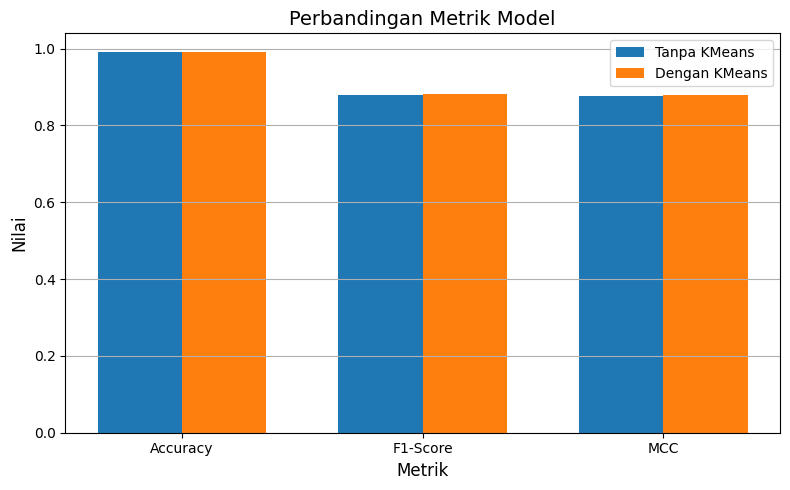

In [ ]:
# Data metrik
metrics = ['Accuracy', 'F1-Score', 'MCC']
no_kmeans = [0.9901, 0.8787, 0.8774]  # Metrik tanpa KMeans
with_kmeans = [0.9903, 0.8811, 0.8801]  # Metrik dengan KMeans

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, no_kmeans, width, label='Tanpa KMeans')
plt.bar(x + width/2, with_kmeans, width, label='Dengan KMeans')

plt.xlabel('Metrik', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.title('Perbandingan Metrik Model', fontsize=14)
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("comparison_metrics_bar_chart.pdf")
plt.show()

### **8.2 Perbandingan Hasil**

In [ ]:
import pandas as pd

# Data perbandingan metrik
comparison_data = {
    "Metrik": ["Accuracy", "F1-Score", "MCC"],
    "Tanpa KMeans": no_kmeans,
    "Dengan KMeans": with_kmeans
}

comparison_df = pd.DataFrame(comparison_data)
print("Tabel Perbandingan Metrik:")
print(comparison_df)

# Simpan tabel ke file CSV
comparison_df.to_csv("comparison_metrics.csv", index=False)


Tabel Perbandingan Metrik:
     Metrik  Tanpa KMeans  Dengan KMeans
0  Accuracy        0.9901         0.9903
1  F1-Score        0.8787         0.8811
2       MCC        0.8774         0.8801
